In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mpi4py import MPI

# 1. Implement Parallel Bifurcation Diagram using `mpi4py`

In [2]:
%%writefile solution-lab-5.py

import numpy as np
import pickle
import sys

from mpi4py import MPI

### define functions for modeling

def logistic_map(x, r):
    return r * x * (1 - x)

def calculate_system_evolution(x, rr_range, n_iterations, n_last_iterations):
    rr_size = len(rr_range)
    
    evolution = np.hstack([
        x * np.ones(shape=(rr_size, 1), dtype=np.float64),
        np.zeros(shape=(rr_size, n_iterations), dtype=np.float64)
    ])

    for i in range(1, n_iterations + 1):
        xx = evolution[:, i - 1]
        evolution[:, i] = logistic_map(xx, rr_range)

    evolution = evolution[:, -n_last_iterations:]
    return evolution.reshape(-1)

### setup mpi environment

comm = MPI.COMM_WORLD
start = MPI.Wtime()

rank = comm.Get_rank()
size = comm.Get_size()
root = 0

### define parameters for modeling

n_params = 1000 if len(sys.argv) == 1 else int(sys.argv[1])
n_iterations = 1000
n_last_iterations = 100

x = 0.5
rr = np.linspace(1, 4, n_params, dtype=np.float64)

### assign modeling parts between processes

rr_count = int(len(rr) / size)
rr_range = rr[rank * rr_count:(rank + 1) * rr_count]
evolution_complete = np.empty(len(rr) * n_last_iterations, dtype=np.float64) if rank == root else None

### perform modeling in every process

evolution_range = calculate_system_evolution(x, rr_range, n_iterations, n_last_iterations)

### gather modeling results in root process

comm.Gather(evolution_range, evolution_complete, root)
end = MPI.Wtime()

if rank == root:
    with open(f'params-{size}.pkl', 'wb') as f:
        pickle.dump(rr, f)

    with open(f'evolution-{size}.pkl', 'wb') as f:
        pickle.dump(evolution_complete, f)
    
    with open(f'time-{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)

Overwriting solution-lab-5.py


In [3]:
n_processes = 2
!mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-5.py

In [4]:
with open(f'params-{n_processes}.pkl', 'rb') as f:
    rr = pickle.load(f)
    
with open(f'evolution-{n_processes}.pkl', 'rb') as f:
    evolution_complete = pickle.load(f)

In [5]:
param_ax = np.repeat(rr, len(evolution_complete) / len(rr))
state_ax = evolution_complete

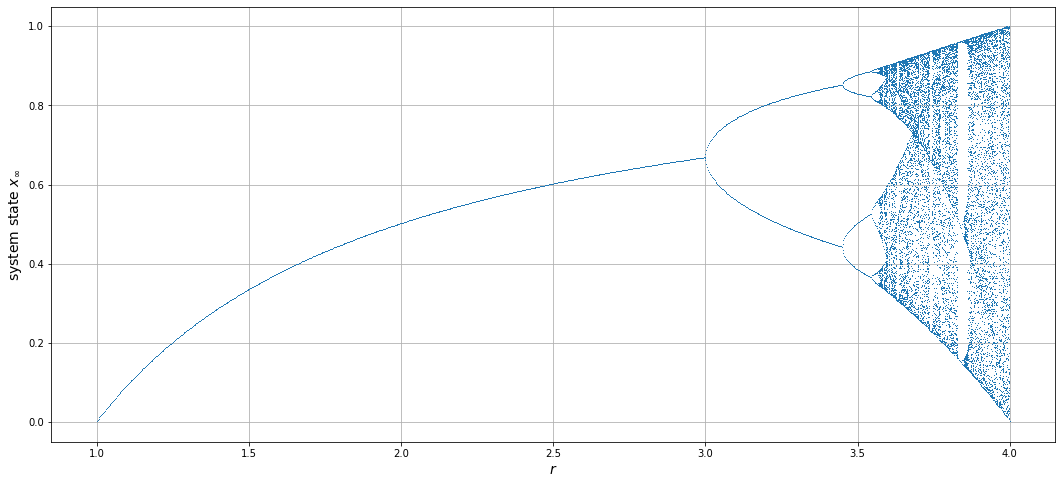

In [6]:
plt.figure(figsize=(18, 8))
plt.plot(param_ax, state_ax, ',', alpha=2.)

plt.xlabel('$r$', fontsize=14)
plt.ylabel('system state $x_{\infty}$', fontsize=14)
plt.grid()
plt.show()

# 2. Plot Speedup for Different Number of Processes

In [7]:
nn = np.logspace(0, 4, base=2, num=5).astype(np.int)

for n_processes in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-5.py {int(5e4)}

In [8]:
time_history = []

for n_processes in nn:
    with open(f'time-{n_processes}.pkl', 'rb') as f:
        time_elapsed = pickle.load(f)
    time_history.append(time_elapsed)

speed_up = time_history[0] / np.array(time_history)

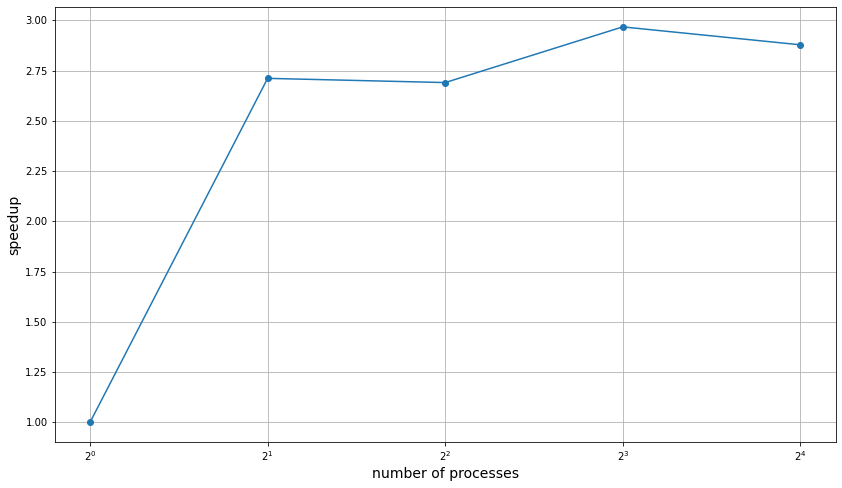

In [9]:
plt.figure(figsize=(14, 8))
plt.plot(nn, speed_up, '-o', alpha=2.)

plt.xlabel('number of processes', fontsize=14)
plt.ylabel('speedup', fontsize=14)

plt.xscale('log', basex=2)
plt.grid()
plt.show()